In [1]:
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *
from utils import *
from scipy.spatial import distance
import seaborn as sns
import umap

In [2]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [3]:
morph_folder = os.path.abspath('/mnt/cube/kai/repositories/morphs/data/stimuli')

results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/morph')
spec_file = os.path.join(morph_folder, 'specs_star.p')

# load all dfs

In [4]:
group_pred_all = pickle.load(open(os.path.join(results_folder, 'norm_robust', 'all_predicted.p'), 'rb'))
group1_behav = pickle.load(open(os.path.join(results_folder, 'group1_behav_agg.p'), 'rb'))
group2_behav = pickle.load(open(os.path.join(results_folder, 'group2_behav_agg.p'), 'rb'))
group3_behav = pickle.load(open(os.path.join(results_folder, 'group3_behav_agg.p'), 'rb'))

In [5]:
group_pred_all.tail()

,index,min_val,max_val,slope,inflection,group,metric
136,eg,1.142385e-01,1.000000,0.022230,61.829764,Group 3,fcosine
137,eh,1.000000e-16,0.960306,0.065932,22.048034,Group 3,fcosine
138,df,1.000000e-16,0.997257,0.151147,54.576789,Group 3,fcosine
139,fg,3.537308e-02,1.000000,0.013060,94.777730,Group 3,fcosine
140,fh,1.000000e-16,0.878523,0.311856,35.409830,Group 3,fcosine


In [6]:
all_groups = pd.concat([group_pred_all,
                       group1_behav, group2_behav, group3_behav]).reset_index(drop=True)

(0.0, 1.0)

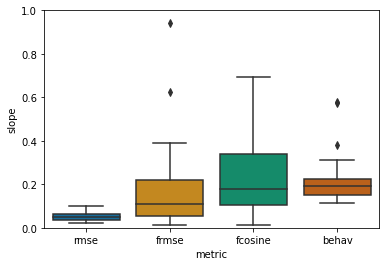

In [8]:
ax = sns.boxplot(y='slope', x='metric',data=all_groups)
ax.set_ylim([0,1])

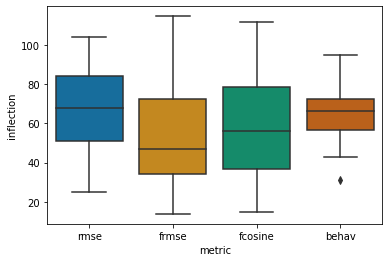

In [9]:
ax = sns.boxplot(y='inflection', x='metric',data=all_groups)

# separate by group

In [10]:
groups = ['Group 1', 'Group 2', 'Group 3']

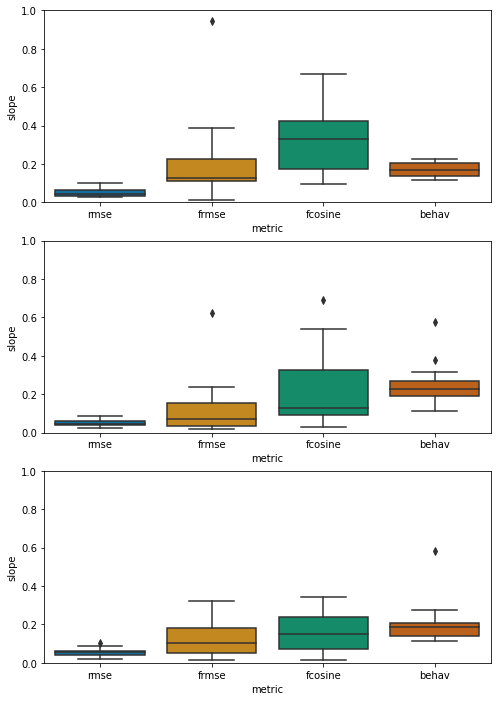

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
for i, group in enumerate(groups):
    sns.boxplot(y='slope', x='metric',data=all_groups[all_groups.group==group], ax=ax[i])
    ax[i].set_ylim([0,1])

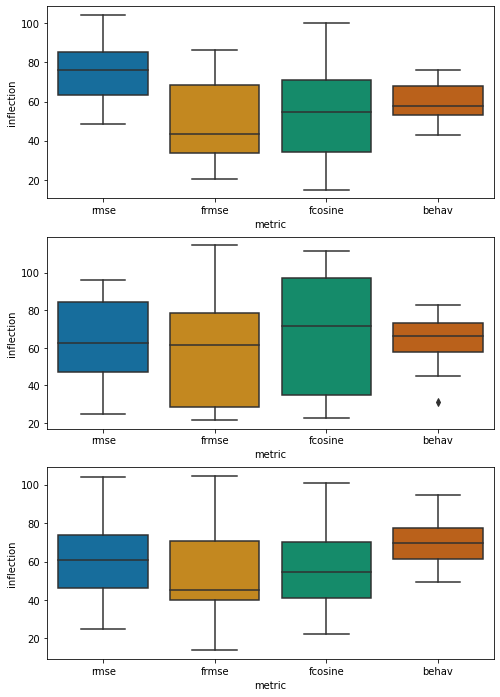

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
for i, group in enumerate(groups):
    sns.boxplot(y='inflection', x='metric',data=all_groups[all_groups.group==group], ax=ax[i])

In [13]:
import statsmodels.formula.api as smf

In [14]:
all_groups['stim'] = all_groups['index']

In [15]:
all_groups.head()

,index,min_val,max_val,slope,inflection,group,metric,stim
0,ae,1.000000e-16,1.000000,0.033214,75.202742,Group 1,rmse,ae
1,af,1.000000e-16,0.945304,0.032496,84.500302,Group 1,rmse,af
2,ag,1.000000e-16,0.860692,0.037051,76.503340,Group 1,rmse,ag
3,ah,1.000000e-16,0.616709,0.065078,56.980419,Group 1,rmse,ah
4,be,7.801580e-03,0.904488,0.054682,84.002627,Group 1,rmse,be


In [16]:
all_groups = all_groups.drop(columns=['index'])

In [18]:
model = smf.mixedlm("slope ~ C(metric, Treatment('behav'))  ",
                    all_groups,
                    groups= "group").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
===================================================================================
Model:                      MixedLM          Dependent Variable:          slope    
No. Observations:           189              Method:                      REML     
No. Groups:                 3                Scale:                       1.3422   
Min. group size:            61               Log-Likelihood:              -297.4534
Max. group size:            64               Converged:                   Yes      
Mean group size:            63.0                                                   
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                 0.209    0.168  1.245 0.213 -0.120  0.537
C(metric, Treatment('behav'))[T.fcosine]  0.074    0.238  0.313 0.755 -0.392  0.540
C(metric, Treatment('behav'))[T.frmse]    0.293    0.238  1.231 0.218 -0.173  0.759
C(metric, Treatment('behav'))[T.rmse]    -0.158    0.238 -0.664 0.507 -0.624  0.308
group Var                                 0.000    0.019                           
===================================================================================

"""

In [19]:
model = smf.mixedlm("inflection ~ C(metric, Treatment('behav'))",
                    all_groups,
                    groups= "group").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
====================================================================================
Model:                      MixedLM          Dependent Variable:          inflection
No. Observations:           189              Method:                      REML      
No. Groups:                 3                Scale:                       510.9316  
Min. group size:            61               Log-Likelihood:              -847.0663 
Max. group size:            64               Converged:                   Yes       
Mean group size:            63.0                                                    
------------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                64.139    3.263 19.659 0.000  57.744 70.533
C(metric, Treatment('behav'))[T.fcosine] -4.673    4.638 -1.007 0.314 -13.764  4.418
C(metric, Treatment('behav'))[T.frmse]   -8.472    4.638 -1.827 0.068 -17.564  0.619
C(metric, Treatment('behav'))[T.rmse]     3.526    4.638  0.760 0.447  -5.565 12.617
group Var                                 0.000    1.169                            
====================================================================================

"""

# absolute difference

In [22]:
all_groups.tail()

,min_val,max_val,slope,inflection,group,metric,stim
184,0.028613,0.944226,0.179967,78.281169,Group 3,behav,eh
185,0.047045,0.882328,0.261025,51.118444,Group 3,behav,cf
186,0.054637,0.939378,0.143298,56.879763,Group 3,behav,df
187,0.079391,0.928413,0.580742,78.445336,Group 3,behav,fg
188,0.063133,0.932895,0.194440,68.749459,Group 3,behav,fh


In [23]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [24]:
tukey = pairwise_tukeyhsd(endog=all_groups['slope'],
                          groups=all_groups['metric'],
                          alpha=0.05)

In [25]:
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
  behav fcosine   0.0743    0.9 -0.5421 0.6908  False
  behav   frmse   0.2928  0.595 -0.3236 0.9092  False
  behav    rmse  -0.1578    0.9 -0.7742 0.4587  False
fcosine   frmse   0.2185 0.7727 -0.4012 0.8381  False
fcosine    rmse  -0.2321 0.7407 -0.8518 0.3876  False
  frmse    rmse  -0.4506  0.238 -1.0702 0.1691  False
-----------------------------------------------------


In [26]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=all_groups['inflection'],
                          groups=all_groups['metric'],
                          alpha=0.05)

In [27]:
print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower    upper  reject
-------------------------------------------------------
  behav fcosine   -4.673 0.7204  -16.699  7.3531  False
  behav   frmse  -8.4725 0.2643 -20.4985  3.5535  False
  behav    rmse   3.5258 0.8588  -8.5003 15.5518  False
fcosine   frmse  -3.7995 0.8281 -15.8887  8.2896  False
fcosine    rmse   8.1987 0.2971  -3.8904 20.2879  False
  frmse    rmse  11.9983 0.0526  -0.0909 24.0874  False
-------------------------------------------------------


# compare mean

In [69]:
def subtract_behav(group_behav, item):
    def _subtract_behav(x):
        try:
            return x[item]-group_behav[x['stim']][item]
        except:
            return np.NaN
    return _subtract_behav

In [70]:
group_behav['ac']['slope']

0.188147708843683

In [38]:
group_df[group_df.metric=='behav'][['stim', 'slope', 'inflection']].set_index('stim').T

stim,ac,ad,ag,ah,bc,bd,bg,bh,ce,de,eg,eh,cf,df,fg,fh
slope,0.188148,0.166949,0.274256,0.201704,0.189083,0.118929,0.231595,0.112464,0.189457,0.131609,0.125694,0.179967,0.261025,0.143298,0.580742,0.194440
inflection,70.222668,76.000209,61.882029,77.347338,69.493321,81.025303,60.827771,72.136789,61.606547,49.383199,94.710017,78.281169,51.118444,56.879763,78.445336,68.749459


In [71]:
normalized_df = pd.DataFrame()
for group in ['Group 1', 'Group 2', 'Group 3']:
    group_df = all_groups[all_groups.group==group].reset_index(drop=True)
    group_behav = group_df[group_df.metric=='behav'][['stim', 'slope', 'inflection']].set_index('stim').T.to_dict('stim')
    group_df['d_slope'] = group_df.apply(lambda x: subtract_behav(group_behav, 'slope')(x), axis=1)
    group_df['d_inflection'] = group_df.apply(lambda x: subtract_behav(group_behav, 'inflection')(x), axis=1)
    normalized_df = pd.concat([normalized_df, group_df]).reset_index(drop=True)

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/pandas/core/frame.py:1554: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


In [72]:
normalized_df

,min_val,max_val,slope,inflection,group,metric,stim,d_slope,d_inflection
0,1.000000e-16,1.000000,0.033214,75.202742,Group 1,rmse,ae,-0.088473,23.820172
1,1.000000e-16,0.945304,0.032496,84.500302,Group 1,rmse,af,-0.082862,28.164192
2,1.000000e-16,0.860692,0.037051,76.503340,Group 1,rmse,ag,-0.081716,28.600583
3,1.000000e-16,0.616709,0.065078,56.980419,Group 1,rmse,ah,-0.071602,-11.165764
4,7.801580e-03,0.904488,0.054682,84.002627,Group 1,rmse,be,-0.113781,18.117609
...,...,...,...,...,...,...,...,...,...
184,2.861325e-02,0.944226,0.179967,78.281169,Group 3,behav,eh,0.000000,0.000000
185,4.704466e-02,0.882328,0.261025,51.118444,Group 3,behav,cf,0.000000,0.000000
186,5.463681e-02,0.939378,0.143298,56.879763,Group 3,behav,df,0.000000,0.000000
187,7.939078e-02,0.928413,0.580742,78.445336,Group 3,behav,fg,0.000000,0.000000


In [73]:
normalized_df.drop(normalized_df[normalized_df['d_slope'] < -0.5].index, inplace = True)
normalized_df.drop(normalized_df[normalized_df['d_slope'] > 0.5].index, inplace = True)
normalized_df.drop(normalized_df[normalized_df['d_inflection'] < -50].index, inplace = True)
normalized_df.drop(normalized_df[normalized_df['d_inflection'] > 50].index, inplace = True)

In [74]:
normalized_df.groupby('metric')[['d_slope', 'd_inflection']].describe()

d_slope                                                              \
          count      mean       std       min       25%       50%       75%   
metric                                                                        
behav      48.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
fcosine    40.0  0.020673  0.176420 -0.461695 -0.083326  0.010288  0.115901   
frmse      39.0 -0.059797  0.128414 -0.362824 -0.117866 -0.081897 -0.019070   
rmse       43.0 -0.141953  0.059070 -0.346372 -0.164504 -0.136627 -0.096561   

                  d_inflection                                              \
              max        count       mean        std        min        25%   
metric                                                                       
behav    0.000000         48.0   0.000000   0.000000   0.000000   0.000000   
fcosine  0.431776         40.0  -5.448180  25.073610 -46.653799 -26.642675   
frmse    0.375197         39.0 -11.092622  20.783759 -48.194453 -24.643711   
rmse    -0.054954         43.0   3.267490  21.343024 -34.586003 -15.406590   

                                         
              50%        75%        max  
metric                                   
behav    0.000000   0.000000   0.000000  
fcosine -2.866867   9.666156  42.675798  
frmse   -9.503288  -0.839642  43.140812  
rmse     5.313899  20.202301  37.785882

In [75]:
normalized_df.groupby('metric')[['d_slope', 'd_inflection']].median()

,d_slope,d_inflection
metric,,
behav,0.000000,0.000000
fcosine,0.010288,-2.866867
frmse,-0.081897,-9.503288
rmse,-0.136627,5.313899


(-0.5, 1.5)

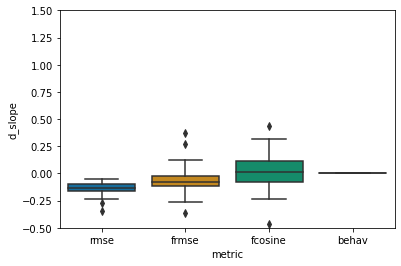

In [76]:
sns.boxplot(x='metric', y='d_slope', data=normalized_df)
plt.ylim([-.5, 1.5])

<AxesSubplot:xlabel='metric', ylabel='d_inflection'>

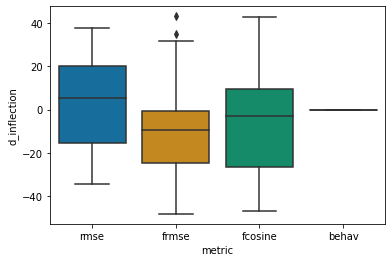

In [58]:
sns.boxplot(x='metric', y='d_inflection', data=normalized_df)
# plt.ylim([-.5, 1.5])

In [68]:
model = smf.mixedlm("d_slope ~ C(metric, Treatment('behav'))",
                    normalized_df,
                    groups= "group").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:                     MixedLM          Dependent Variable:          d_slope 
No. Observations:          170              Method:                      REML    
No. Groups:                3                Scale:                       0.0052  
Min. group size:           54               Log-Likelihood:              191.6001
Max. group size:           60               Converged:                   Yes     
Mean group size:           56.7                                                  
---------------------------------------------------------------------------------
                                         Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                                0.000    0.020 0.000 1.000 -0.040  0.040
C(metric, Treatment('behav'))[T.fcosine] 0.134    0.015 8.727 0.000  0.104  0.164
C(metric, Treatment('behav'))[T.frmse]   0.109    0.016 7.009 0.000  0.078  0.139
C(metric, Treatment('behav'))[T.rmse]    0.142    0.015 9.405 0.000  0.112  0.172
group Var                                0.001    0.014                          
=================================================================================

"""

In [60]:
model = smf.mixedlm("d_inflection ~ C(metric, Treatment('behav'))",
                    normalized_df,
                    groups= "group").fit()

model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Mixed Linear Model Regression Results
=====================================================================================
Model:                     MixedLM          Dependent Variable:          d_inflection
No. Observations:          170              Method:                      REML        
No. Groups:                3                Scale:                       347.8918    
Min. group size:           54               Log-Likelihood:              -730.1953   
Max. group size:           60               Converged:                   Yes         
Mean group size:           56.7                                                      
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                 -0.000    3.737 -0.000 1.000  -7.324  7.324
C(metric, Treatment('behav'))[T.fcosine]  -5.410    3.993 -1.355 0.176 -13.237  2.417
C(metric, Treatment('behav'))[T.frmse]   -11.436    4.025 -2.842 0.004 -19.324 -3.548
C(metric, Treatment('behav'))[T.rmse]      2.992    3.919  0.763 0.445  -4.689 10.672
group Var                                 20.145    1.412                            
=====================================================================================

"""